In [67]:
import pandas as pd 
import numpy as np 
import seaborn as sns

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

In [68]:
data = pd.read_csv('/kaggle/input/air-passengers/AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [69]:
data = data.rename(columns={"#Passengers": "Passengers"}, inplace=False)
data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [70]:
data.columns = ['Month','Passengers']
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Plot time series data

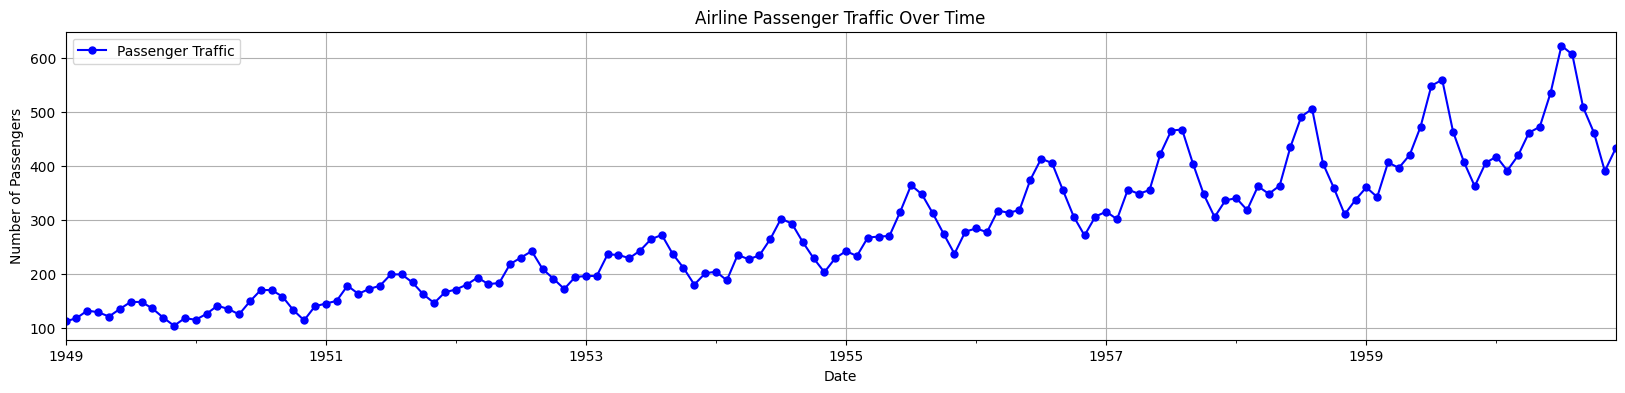

In [71]:
data.plot(y='Passengers', figsize=(20, 4), color='blue', linestyle='-', marker='o', markersize=5, label='Passenger Traffic')
plt.grid(True)
plt.legend(loc='best')
plt.title('Airline Passenger Traffic Over Time')
plt.xlabel('Date')  
plt.ylabel('Number of Passengers')  
plt.show(block=False)

# Missing value treatment

## Mean imputation

In [72]:
data['Passengers_Mean_Imputation'] = data['Passengers'].fillna(data['Passengers'].mean())

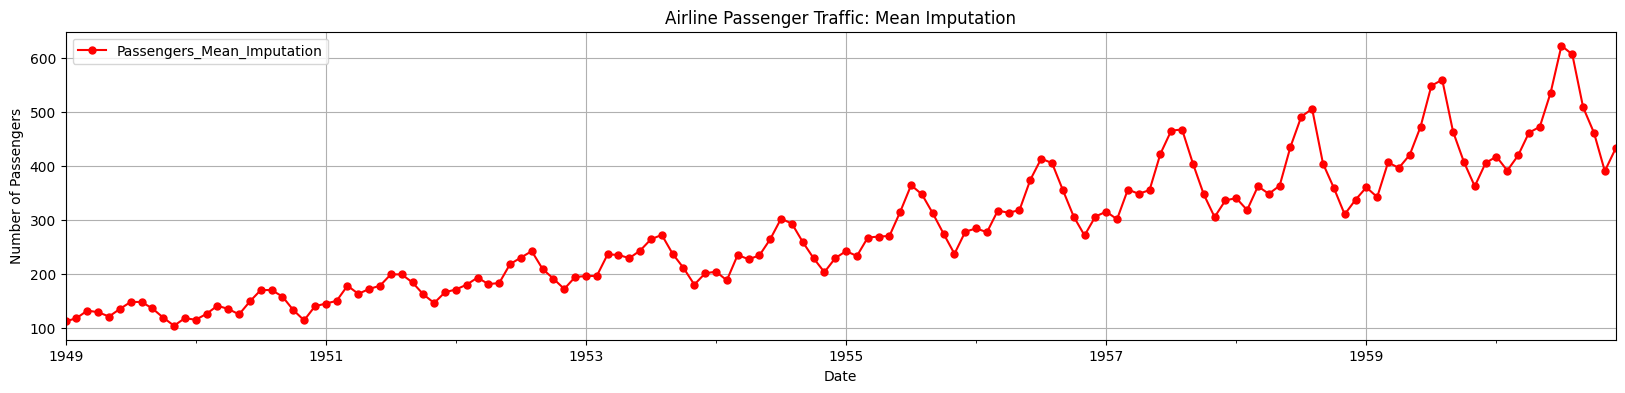

In [73]:
data[['Passengers_Mean_Imputation']].plot(figsize=(20, 4), grid=True, legend=True, color='red', linestyle='-', marker='o', markersize=5)
plt.title('Airline Passenger Traffic: Mean Imputation')
plt.xlabel('Date')  
plt.ylabel('Number of Passengers') 
plt.show(block=False)

## Linear interpolation

In [74]:
data['Passengers_Linear_Interpolation'] = data['Passengers'].interpolate(method='linear')

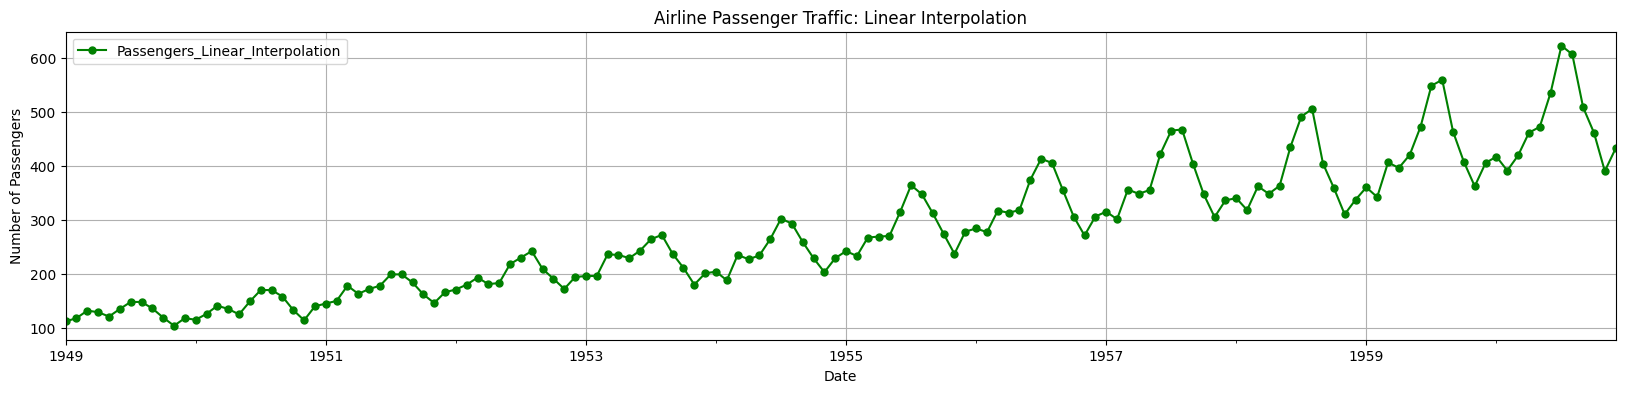

In [75]:
data[['Passengers_Linear_Interpolation']].plot(figsize=(20, 4), grid=True, legend=True, color='green', linestyle='-', marker='o', markersize=5)
plt.title('Airline Passenger Traffic: Linear Interpolation')
plt.xlabel('Date')  
plt.ylabel('Number of Passengers')  
plt.show(block=False)

In [76]:
data.head()

,Passengers,Passengers_Mean_Imputation,Passengers_Linear_Interpolation
Month,,,
1949-01-01,112,112,112
1949-02-01,118,118,118
1949-03-01,132,132,132
1949-04-01,129,129,129
1949-05-01,121,121,121


In [77]:
data['Passengers'] = data['Passengers_Linear_Interpolation']
data.drop(columns=['Passengers_Mean_Imputation','Passengers_Linear_Interpolation'],inplace=True)
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# Outlier detection

## Box plot and interquartile range

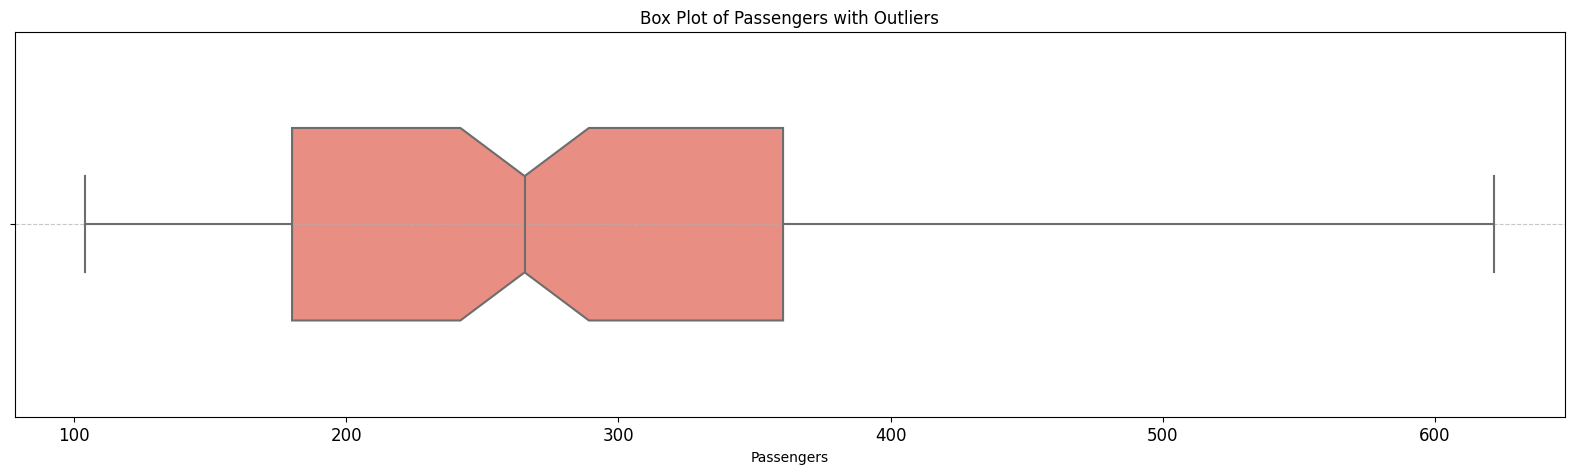

In [78]:
import seaborn as sns
plt.figure(figsize=(20, 5))

sns.boxplot(x=data['Passengers'], color='salmon', width=0.5, notch=True)

plt.title('Box Plot of Passengers with Outliers')
plt.xlabel('Passengers')
plt.xticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Histogram plot

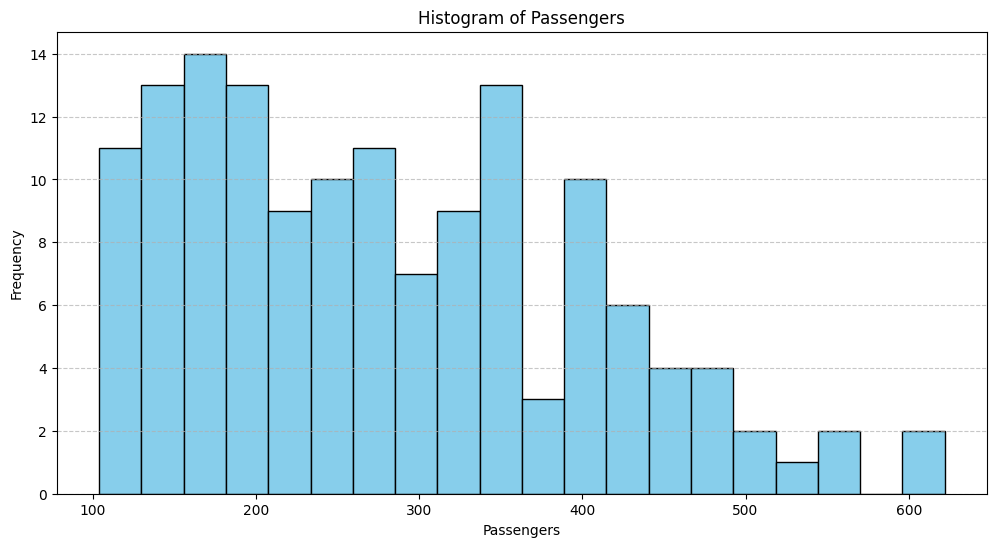

In [79]:
plt.figure(figsize=(12, 6))
plt.hist(data['Passengers'], bins=20, color='skyblue', edgecolor='black')

plt.title('Histogram of Passengers')
plt.xlabel('Passengers')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Time series Decomposition

## Additive seasonal decomposition

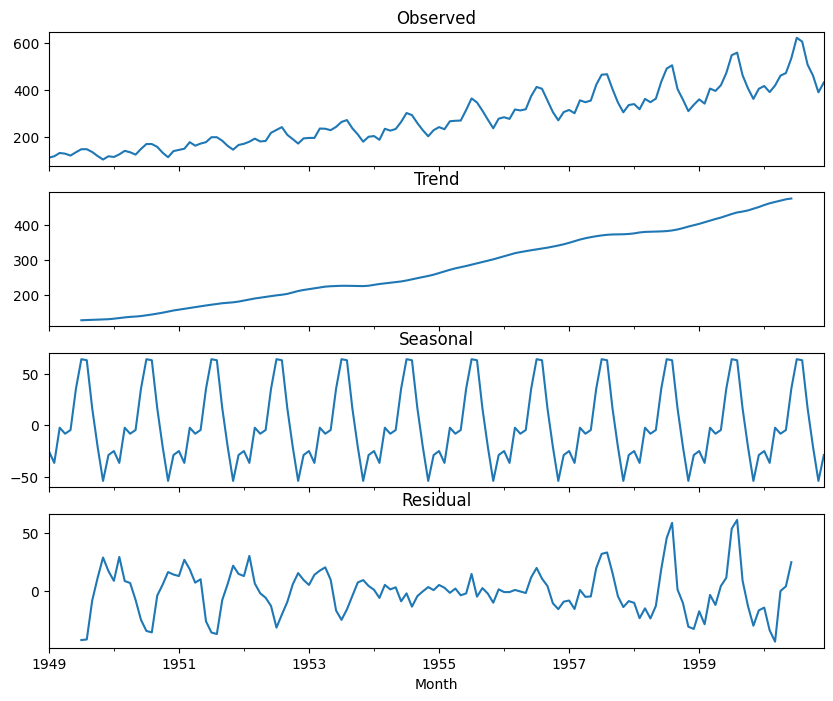

In [80]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform decomposition
result = seasonal_decompose(data['Passengers'], model='additive')  
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

result.observed.plot(ax=ax1, title='Observed')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
result.resid.plot(ax=ax4, title='Residual')

plt.show()

## Multiplicative seasonal decomposition

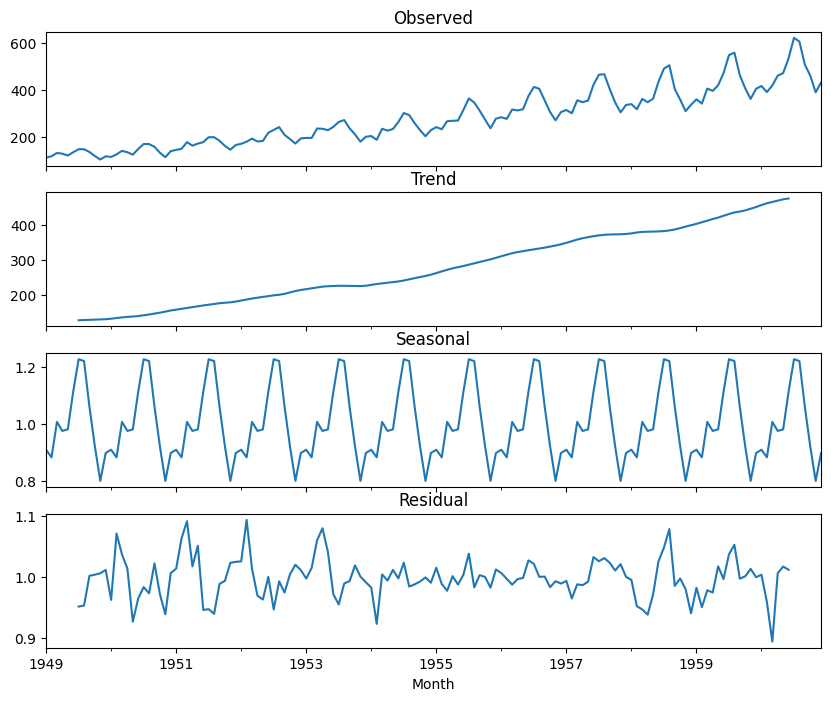

In [81]:
result = seasonal_decompose(data['Passengers'], model='multiplicative') 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

result.observed.plot(ax=ax1, title='Observed')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
result.resid.plot(ax=ax4, title='Residual')

plt.show()

# Build and evaluate time series forecast

## Split time series data into training and test set

In [82]:
train_len = 120
train = data[:train_len]  # first 120 months as the training set
test = data[train_len:]  # last 24 months as the out-of-time test set

# Simple time series methods

## Naive method

In [83]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Passengers'].iloc[-1]

### Plot train, test and forecas

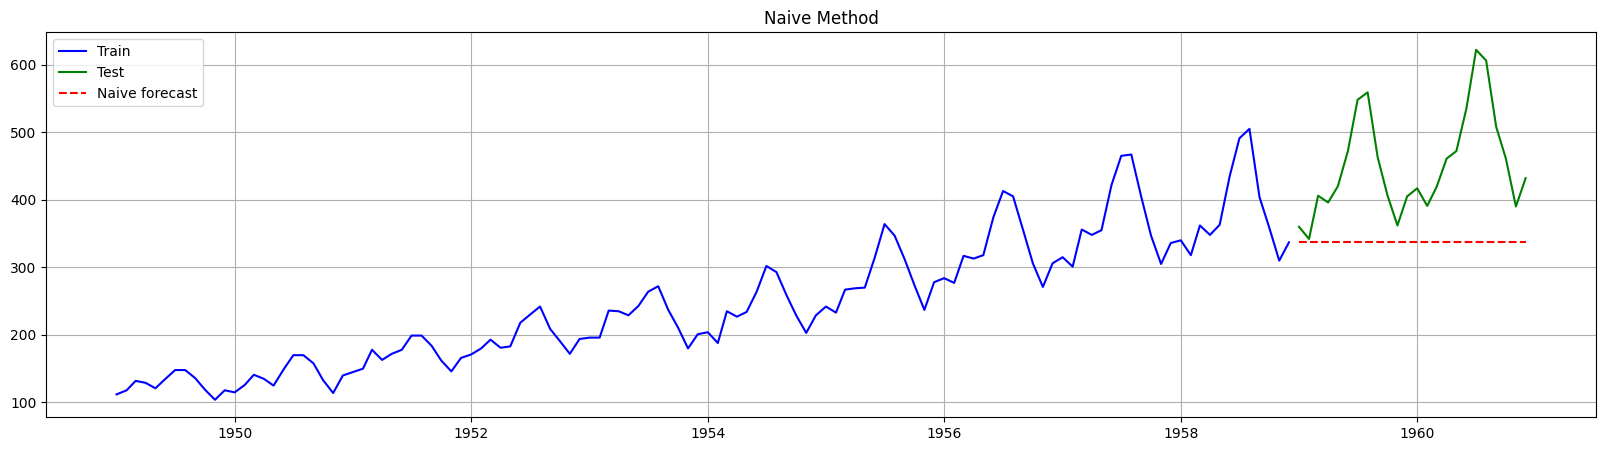

In [84]:
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(train['Passengers'], label='Train', color='blue')
plt.plot(test['Passengers'], label='Test', color='green')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast', linestyle='--', color='red')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()


In [85]:
# Calculate RMSE and MAPE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_naive['naive_forecast'])/test['Passengers'])*100,2)

In [86]:
results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.33,23.58


## Simple average method

In [87]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Passengers'].mean()

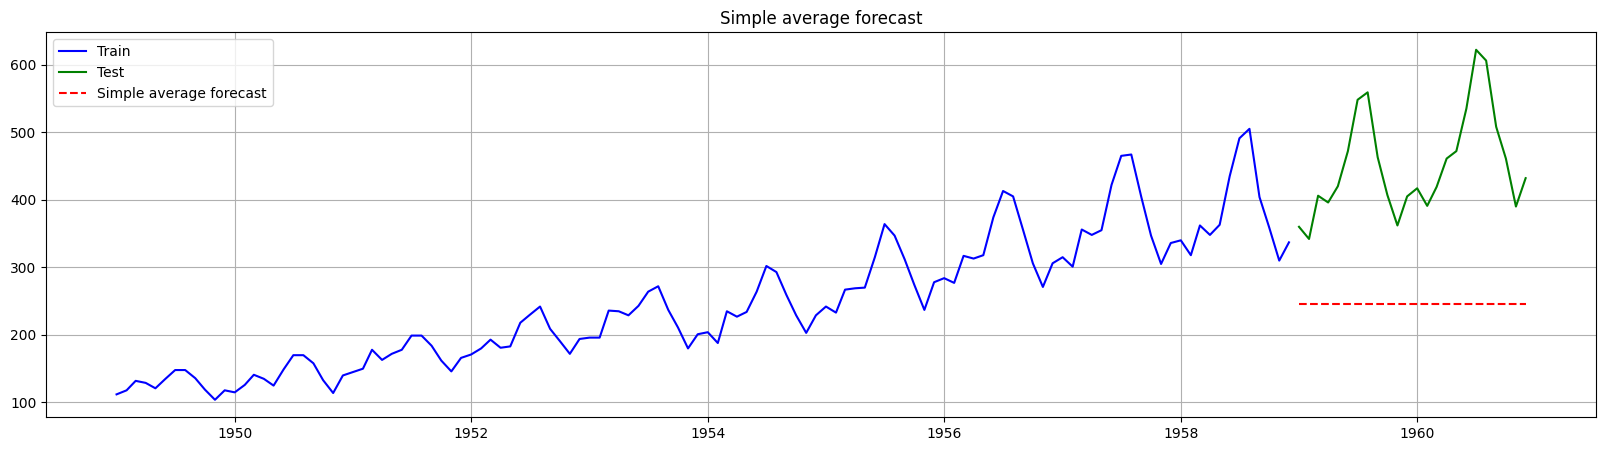

In [88]:
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(train['Passengers'], label='Train', color='blue')
plt.plot(test['Passengers'], label='Test', color='green')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast', linestyle='--', color='red')
plt.legend(loc='best')
plt.title('Simple average forecast')
plt.show()

In [89]:
# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_avg['avg_forecast'])/test['Passengers'])*100,2)

In [90]:
tempResults = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.33,23.58
0,Simple average method,219.44,44.23


## Simple moving average method

In [91]:
y_hat_sma = data.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = data['Passengers'].rolling(ma_window).mean()

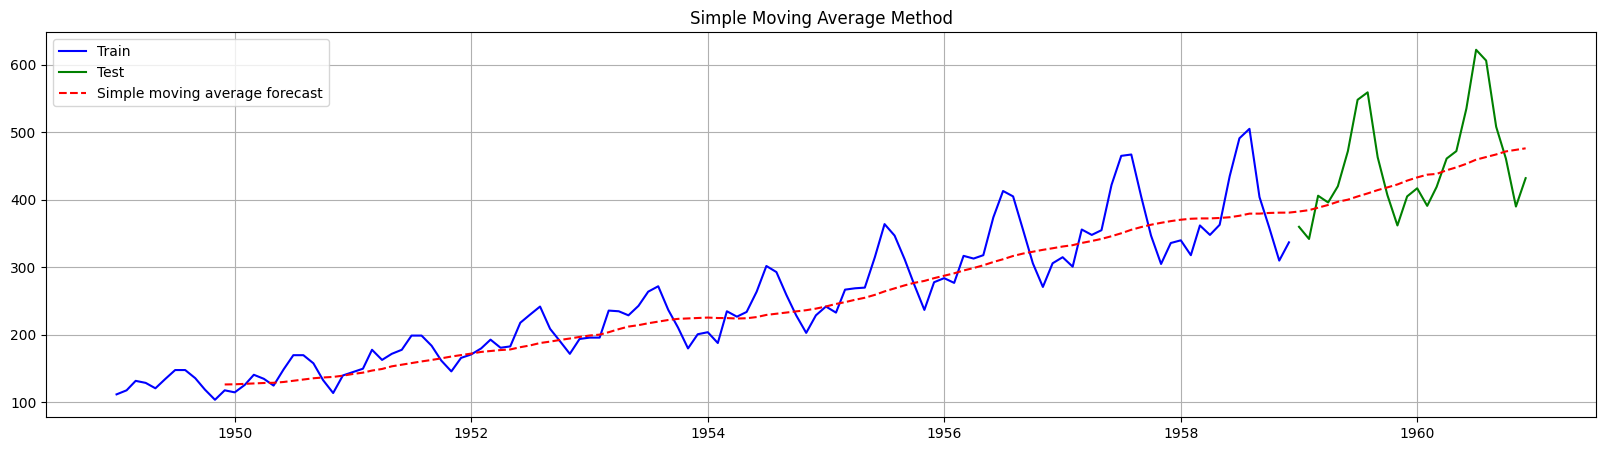

In [92]:
#Plot train, test and forecast
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['Passengers'], label='Train',color='blue')
plt.plot(test['Passengers'], label='Test',color='green')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast',linestyle='--', color='red')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [93]:
#Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sma['sma_forecast'][train_len:])/test['Passengers'])*100,2)

In [94]:
tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.33,23.58
0,Simple average method,219.44,44.23
0,Simple moving average forecast,72.40,11.23
